In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


warnings.filterwarnings('ignore')

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/impact.csv')
print(data.head())

      Names    Age Gender  Mobile Phone  Mobile Operating System   \
0       Ali  21-25    Male           Yes                  Android   
1     Bilal  21-25    Male           Yes                  Android   
2    Hammad  21-25    Male           Yes                      IOS   
3  Abdullah  21-25    Male           Yes                  Android   
4     Waqar  21-25    Male           Yes                      IOS   

  Mobile phone use for education Mobile phone activities Helpful for studying  \
0                      Sometimes            Social Media                  Yes   
1                      Sometimes            Social Media                  Yes   
2                      Sometimes            All of these                  Yes   
3                     Frequently            All of these                  Yes   
4                     Frequently            All of these                  Yes   

     Educational Apps Daily usages Performance impact      Usage distraction  \
0  Educational Vid

In [4]:
#Data Cleaning


# 1. Handling Missing Data
# Imputation
# Impute numerical columns with mean or median
for col in data.select_dtypes(include=[np.number]).columns:
    data[col].fillna(data[col].median(), inplace=True)

# Impute categorical columns with mode
for col in data.select_dtypes(include=['object', 'category']).columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# KNN imputation (if needed for more sophisticated imputation)
# imputer = KNNImputer(n_neighbors=5)
# data_imputed = imputer.fit_transform(data.select_dtypes(include=[np.number]))
# data[data.select_dtypes(include=[np.number]).columns] = data_imputed

# Deletion: Remove columns with more than a certain threshold of missing values
threshold = 0.6
data = data.loc[:, data.isnull().mean() < threshold]

# 2. Removing Duplicates
data.drop_duplicates(inplace=True)

# 3. Modifying Data Types
# Converting numerical data stored as strings to appropriate numerical types
for col in data.columns:
    if data[col].dtype == 'object':
        try:
            data[col] = pd.to_numeric(data[col])
        except ValueError:
            pass

# Standardizing date formats (if there are date columns)
for col in data.columns:
    if data[col].dtype == 'object':
        try:
            data[col] = pd.to_datetime(data[col])
        except ValueError:
            pass

# Ensuring categorical variables are correctly identified and encoded
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category')

# Encode categorical variables using LabelEncoder
le = LabelEncoder()
for col in data.select_dtypes(include=['category']).columns:
    data[col] = le.fit_transform(data[col])

# Save the cleaned dataset
data.to_csv('/content/drive/My Drive/Colab Notebooks/cleaned_dataset.csv', index=False)

# Load the cleaned dataset
cleaned_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cleaned_dataset.csv')

# Display the first few rows of the cleaned dataset
print(cleaned_data.head())

   Names  Age  Gender   Mobile Phone   Mobile Operating System   \
0      8    1        1              0                         0   
1     21    1        1              0                         0   
2     32    1        1              0                         1   
3      2    1        1              0                         0   
4     93    1        1              0                         1   

   Mobile phone use for education  Mobile phone activities  \
0                               3                        2   
1                               3                        2   
2                               3                        0   
3                               0                        0   
4                               0                        0   

   Helpful for studying  Educational Apps  Daily usages  Performance impact  \
0                     1                 0             1                   0   
1                     1                 0             1           

In [5]:
#Data Transformation


# Feature Scaling and Normalization
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply Standard Scaling
data_scaled = pd.DataFrame(scaler.fit_transform(data.select_dtypes(include=[np.number])), columns=data.select_dtypes(include=[np.number]).columns)

# Apply Min-Max Scaling
data_minmax_scaled = pd.DataFrame(minmax_scaler.fit_transform(data.select_dtypes(include=[np.number])), columns=data.select_dtypes(include=[np.number]).columns)

# One-Hot Encoding for categorical variables
ohe = OneHotEncoder(sparse_output=False)
data_ohe = pd.DataFrame(ohe.fit_transform(data.select_dtypes(include=['category'])), columns=ohe.get_feature_names_out(data.select_dtypes(include=['category']).columns))

# Combine scaled and encoded features
data_transformed = pd.concat([data_scaled, data_ohe], axis=1)

# Feature Engineering
# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
data_poly = pd.DataFrame(poly.fit_transform(data_transformed), columns=poly.get_feature_names_out(data_transformed.columns))

# Save the cleaned and transformed dataset
data_poly.to_csv('cleaned_transformed_dataset.csv', index=False)

# Load the cleaned and transformed dataset
cleaned_data = pd.read_csv('cleaned_transformed_dataset.csv')

# Display the first few rows of the cleaned and transformed dataset
print(cleaned_data.head())

      Names       Age   Gender   Mobile Phone   Mobile Operating System   \
0 -1.437674 -0.045798  0.484322            0.0                 -0.484322   
1 -0.987318 -0.045798  0.484322            0.0                 -0.484322   
2 -0.606248 -0.045798  0.484322            0.0                  2.064742   
3 -1.645531 -0.045798  0.484322            0.0                 -0.484322   
4  1.506960 -0.045798  0.484322            0.0                  2.064742   

   Mobile phone use for education  Mobile phone activities  \
0                        0.818044                 0.428623   
1                        0.818044                 0.428623   
2                        0.818044                -0.670411   
3                       -1.519224                -0.670411   
4                       -1.519224                -0.670411   

   Helpful for studying  Educational Apps  Daily usages  ...  \
0              0.204124         -0.770154     -0.268328  ...   
1              0.204124         -0.770154 

In [6]:
# Random Forest Model

# Define the feature columns
feature_columns = [
    'Age', 'Gender ', 'Mobile Phone ', 'Mobile Operating System ',
    'Mobile phone use for education', 'Mobile phone activities',
    'Helpful for studying', 'Educational Apps', 'Daily usages',
    'Usage distraction', 'Attention span', 'Useful features',
    'Health Risks', 'Beneficial subject', 'Usage symptoms',
    'Symptom frequency', 'Health precautions'
]

# Select the features and target from the dataframe
data = data.dropna(subset=['Performance impact'])  # Drop rows with missing target
X = data[feature_columns]
y = data['Performance impact']

# Handle categorical variables (using one-hot encoding)
X = pd.get_dummies(X)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Address class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a reduced parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],  # Reduced number of estimators
    'max_depth': [None, 10],    # Reduced depth options
    'min_samples_split': [2, 5],# Reduced split options
    'min_samples_leaf': [1, 2], # Reduced leaf options
    'class_weight': [None, 'balanced']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=2, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Ensure target names are strings
target_names = le.inverse_transform(np.arange(len(le.classes_))).astype(str).tolist()
report = classification_report(y_test, y_pred, target_names=target_names)

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.7142857142857143
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.58      0.54        12
           1       0.77      1.00      0.87        10
           2       0.73      0.47      0.57        17
           3       0.83      0.71      0.77        14
           4       0.77      1.00      0.87        10

    accuracy                           0.71        63
   macro avg       0.72      0.75      0.72        63
weighted avg       0.72      0.71      0.70        63



In [7]:
#Logistic Regression


# Define the feature columns
feature_columns = [
    'Age', 'Gender ', 'Mobile Phone ', 'Mobile Operating System ',
    'Mobile phone use for education', 'Mobile phone activities',
    'Helpful for studying', 'Educational Apps', 'Daily usages',
    'Usage distraction', 'Attention span', 'Useful features',
    'Health Risks', 'Beneficial subject', 'Usage symptoms',
    'Symptom frequency', 'Health precautions'
]

# Select the features and target from the dataframe
data = data.dropna(subset=['Performance impact'])  # Drop rows with missing target
X = data[feature_columns]
y = data['Performance impact']

# Handle categorical variables (using one-hot encoding)
X = pd.get_dummies(X)

# Convert boolean columns to numeric (if any)
X = X.astype(float)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Address class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['lbfgs', 'saga', 'liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=200, random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
# Ensure target names are strings
target_names = le.inverse_transform(np.unique(y_res)).astype(str)
report = classification_report(y_test, y_pred, target_names=target_names)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.5714285714285714
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.42      0.38        12
           1       0.64      0.90      0.75        10
           2       0.43      0.18      0.25        17
           3       0.77      0.71      0.74        14
           4       0.60      0.90      0.72        10

    accuracy                           0.57        63
   macro avg       0.56      0.62      0.57        63
weighted avg       0.55      0.57      0.54        63



In [8]:
#Decision Tree

# Define the feature columns
feature_columns = [
    'Age', 'Gender ', 'Mobile Phone ', 'Mobile Operating System ',
    'Mobile phone use for education', 'Mobile phone activities',
    'Helpful for studying', 'Educational Apps', 'Daily usages',
    'Usage distraction', 'Attention span', 'Useful features',
    'Health Risks', 'Beneficial subject', 'Usage symptoms',
    'Symptom frequency', 'Health precautions'
]

# Select the features and target from the dataframe
data = data.dropna(subset=['Performance impact'])  # Drop rows with missing target
X = data[feature_columns]
y = data['Performance impact']

# Handle categorical variables (using one-hot encoding)
X = pd.get_dummies(X)

# Convert boolean columns to numeric (if any)
X = X.astype(float)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Address class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
# Ensure target names are strings
target_names = le.inverse_transform(np.unique(y_res)).astype(str).tolist()
report = classification_report(y_test, y_pred, target_names=target_names)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.5396825396825397
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29        12
           1       0.70      0.70      0.70        10
           2       0.67      0.47      0.55        17
           3       0.70      0.50      0.58        14
           4       0.53      0.80      0.64        10

    accuracy                           0.54        63
   macro avg       0.57      0.56      0.55        63
weighted avg       0.58      0.54      0.55        63



In [13]:
# ANN

# Define the feature columns
feature_columns = [
    'Age', 'Gender ', 'Mobile Phone ', 'Mobile Operating System ',
    'Mobile phone use for education', 'Mobile phone activities',
    'Helpful for studying', 'Educational Apps', 'Daily usages',
    'Usage distraction', 'Attention span', 'Useful features',
    'Health Risks', 'Beneficial subject', 'Usage symptoms',
    'Symptom frequency', 'Health precautions'
]

# Select the features and target from the dataframe
data = data.dropna(subset=['Performance impact'])  # Drop rows with missing target
X = data[feature_columns]
y = data['Performance impact']

# Handle categorical variables (using one-hot encoding)
X = pd.get_dummies(X)

# Convert boolean columns to numeric (if any)
X = X.astype(float)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Address class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the target variable
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_classes, y_pred_classes)

print(f"Accuracy: {accuracy}")


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.2063 - loss: 1.7047 - val_accuracy: 0.2667 - val_loss: 1.6819
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3112 - loss: 1.5570 - val_accuracy: 0.2333 - val_loss: 1.6274
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3182 - loss: 1.5082 - val_accuracy: 0.3333 - val_loss: 1.5796
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5380 - loss: 1.4039 - val_accuracy: 0.4667 - val_loss: 1.5372
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6151 - loss: 1.3321 - val_accuracy: 0.4333 - val_loss: 1.4985
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5915 - loss: 1.3249 - val_accuracy: 0.4333 - val_loss: 1.4589
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5567 - loss: 1.2832 - val_accuracy: 0.4667 - val_loss: 1.4208
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5756 - loss: 1.2594 - val_accuracy: 0.5000 - val_loss

Performance impact    0
Daily usages          0
dtype: int64


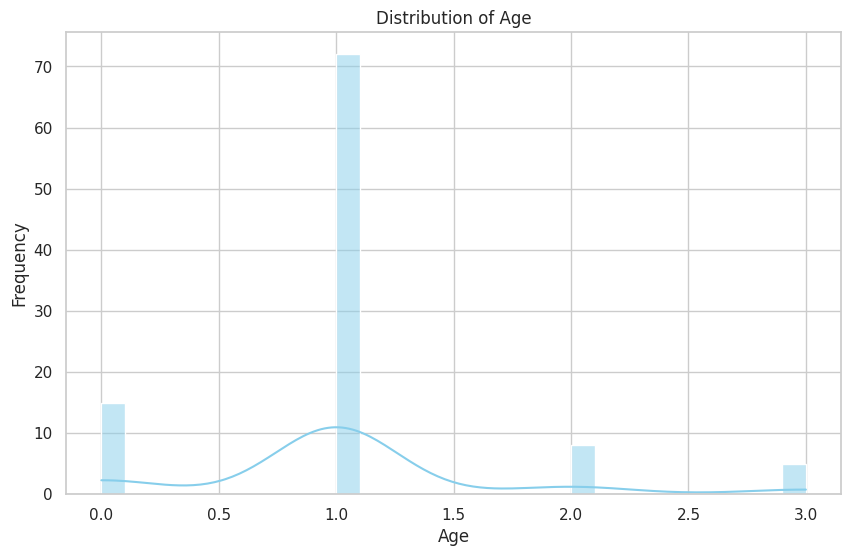

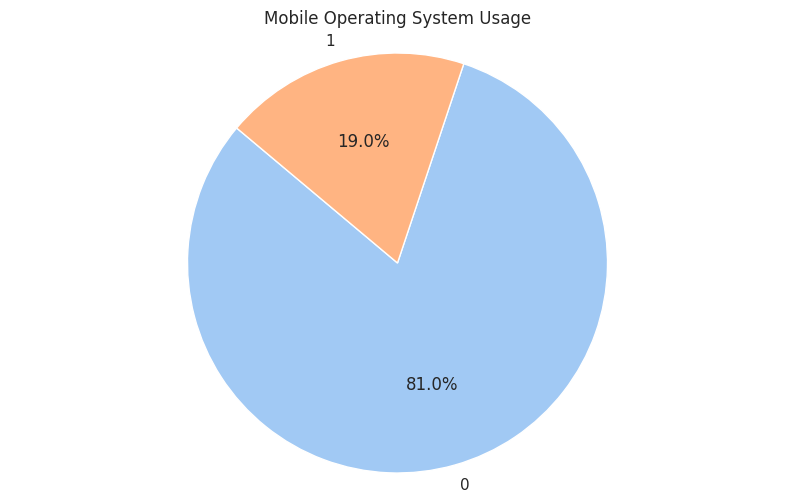

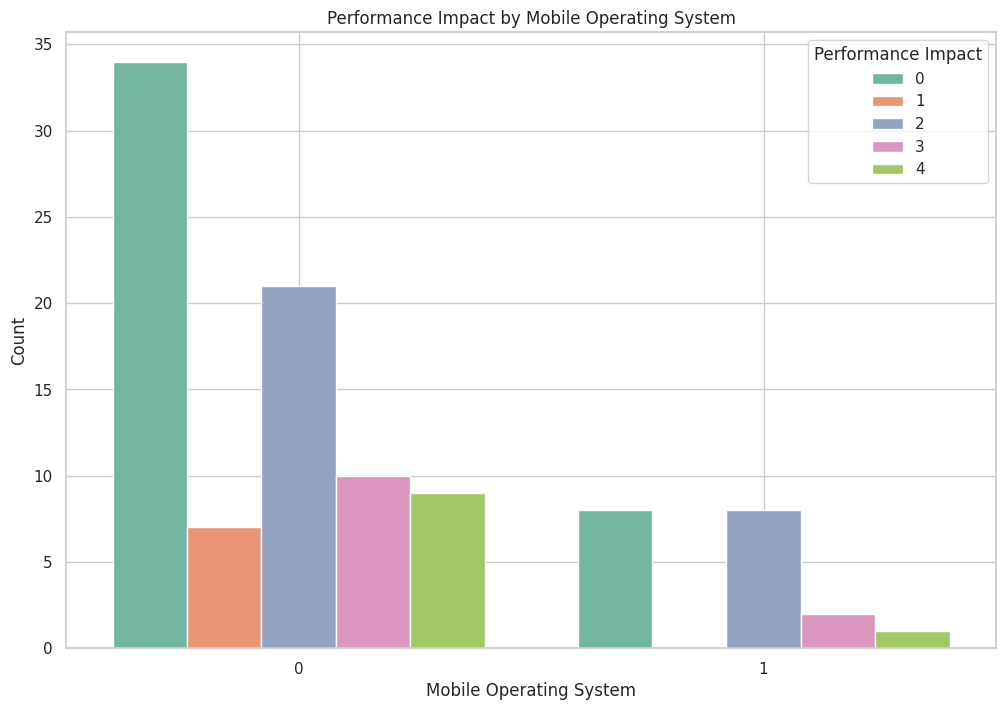

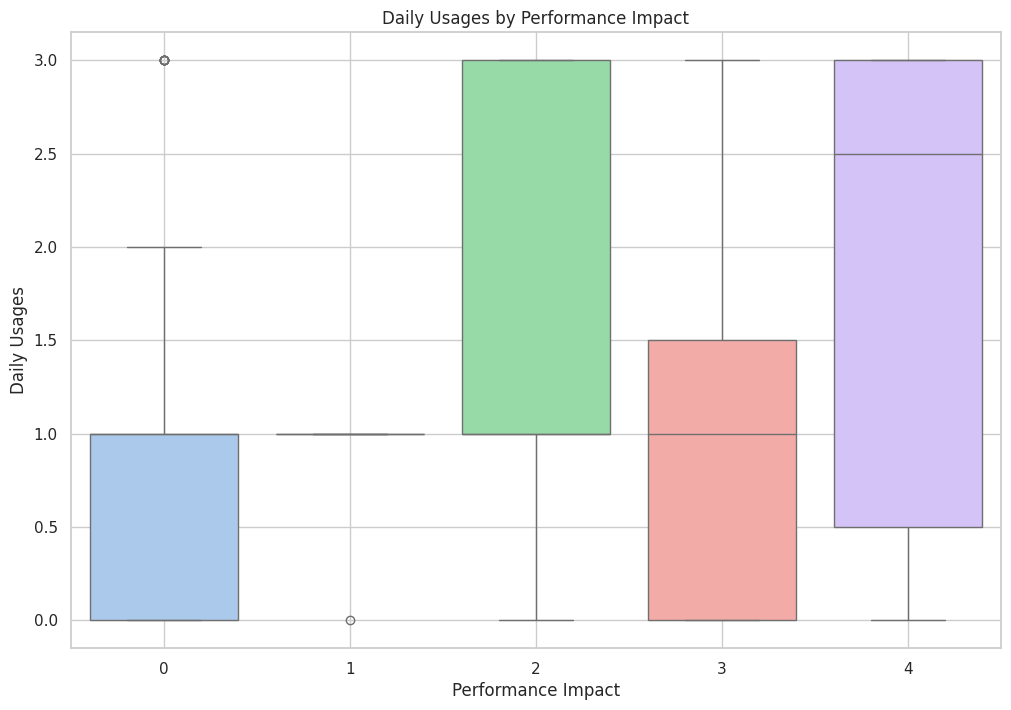

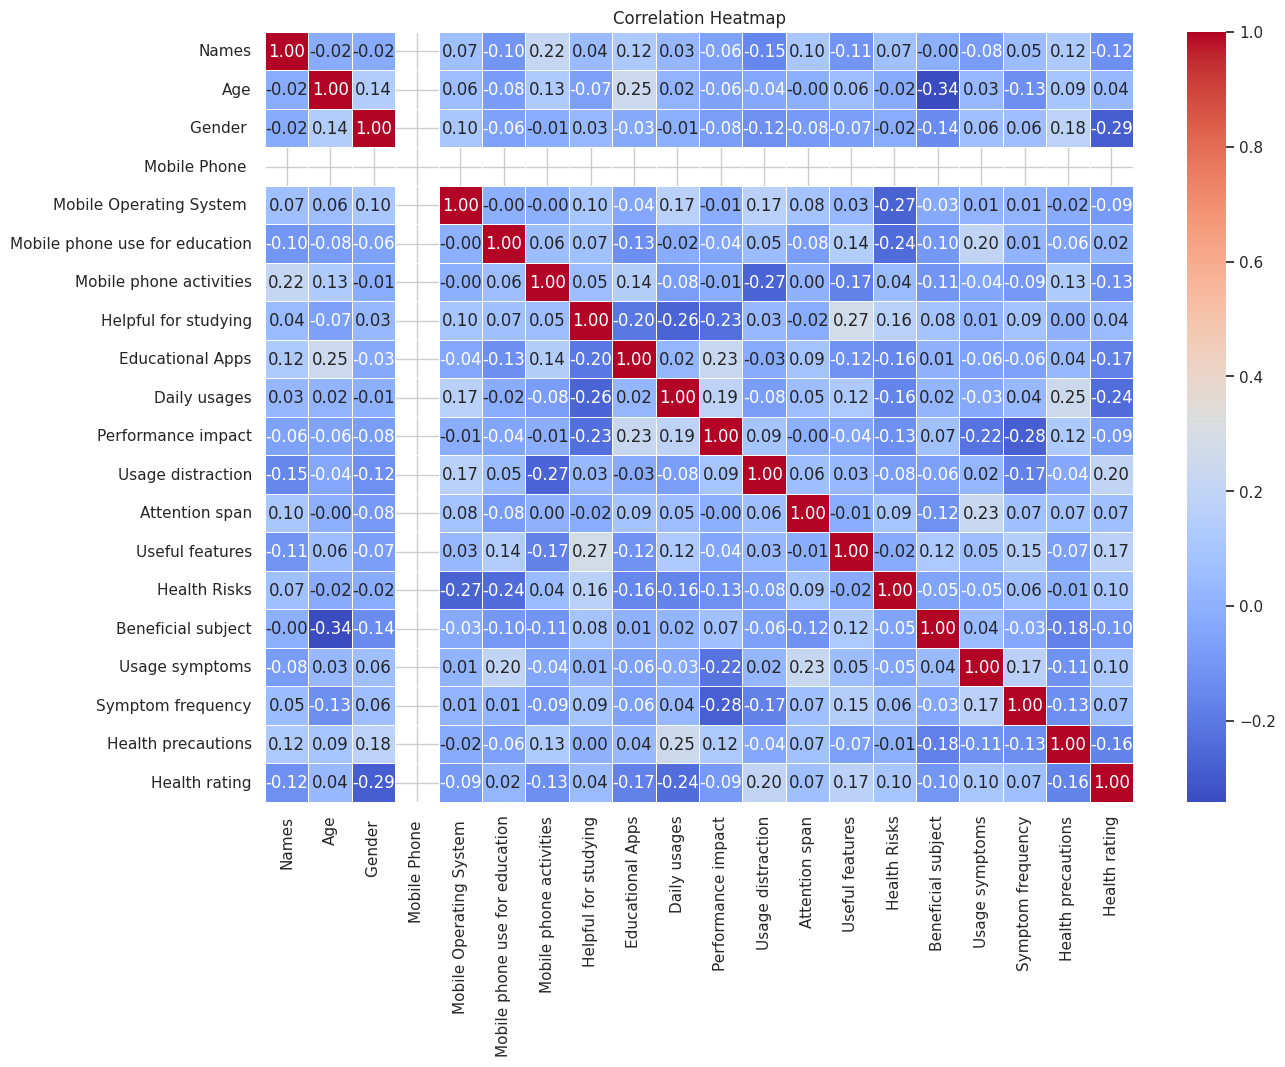

In [10]:
# EDA/Visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Check for NaN values in 'Performance impact' and 'Daily usages' columns
print(data[['Performance impact', 'Daily usages']].isna().sum())

# Drop rows with NaN values in 'Performance impact' and 'Daily usages' columns
data = data.dropna(subset=['Performance impact', 'Daily usages'])

# Convert 'Performance impact' to a categorical type for better visualization
data['Performance impact'] = data['Performance impact'].astype('category')

# Set the style for seaborn
sns.set(style="whitegrid")

# Visualization 1: Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Visualization 2: Pie chart of Mobile Operating System usage
plt.figure(figsize=(10, 6))
os_counts = data['Mobile Operating System '].value_counts()
plt.pie(os_counts, labels=os_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=140)
plt.title('Mobile Operating System Usage')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Visualization 3: Performance Impact by Mobile Operating System
plt.figure(figsize=(12, 8))
sns.countplot(x='Mobile Operating System ', hue='Performance impact', data=data, palette='Set2')
plt.title('Performance Impact by Mobile Operating System')
plt.xlabel('Mobile Operating System')
plt.ylabel('Count')
plt.legend(title='Performance Impact')
plt.grid(True)
plt.show()

# Visualization 4: Boxplot of Daily Usages by Performance Impact
plt.figure(figsize=(12, 8))
sns.boxplot(x='Performance impact', y='Daily usages', data=data, palette='pastel')
plt.title('Daily Usages by Performance Impact')
plt.xlabel('Performance Impact')
plt.ylabel('Daily Usages')
plt.grid(True)
plt.show()

# Visualization 5: Correlation Heatmap
plt.figure(figsize=(14, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()
